In [1]:
# Import my code
from tensorfactorization.utils import (defactorizing_CP, create_initial_data, random_cp_with_noise)
from tensorfactorization.multiplicative import (tensor_factorization_cp_multiplicative, tensor_factorization_cp_multiplicative_poisson)
from tensorfactorization.poisson import (BacktrackingWarning, tensor_factorization_cp_poisson, tensor_factorization_cp_poisson_fixed_step_size)
from data.data_imports import (load_IL2data, load_indian_pines)#, load_kinetic, load_covid19_serology

from toolkit.constants import (
    picture_folder, data_folder, 
    error_label, iteration_label, tensor_dimension_label, time_label, 
    xscale_convergence_data, xscale_convergence, yscale_convergence
)
from toolkit.step_size import (show_step_sizes)

#%matplotlib widget
import tensorly as tl
import numpy as np
import math
import random
import matplotlib.pyplot as plt
import pickle # use pickle to save results to disk
import warnings

from copy import deepcopy

# Create Data

 
 
 Sigma = 0.5
Dimension of new tensor: [54, 133, 5, 5]
doing 10 iteration steps, with norm: 540.6520786379481
done with factorization
Dimension of new tensor: [99, 21, 70]
doing 6 iteration steps, with norm: 473.0561097496629
done with factorization
Dimension of new tensor: [84, 30, 42]
doing 6 iteration steps, with norm: 369.77826103372524
done with factorization
Dimension of new tensor: [30, 142, 30]
doing 8 iteration steps, with norm: 453.24113972492495
done with factorization
Dimension of new tensor: [167, 24, 28]
doing 6 iteration steps, with norm: 378.86692741887754
done with factorization
Dimension of new tensor: [159, 31, 26]
doing 8 iteration steps, with norm: 396.88123822553257
done with factorization
Dimension of new tensor: [39, 188, 3, 4]
doing 6 iteration steps, with norm: 413.6256632211941
done with factorization
Dimension of new tensor: [192, 22, 10, 4]
doing 7 iteration steps, with norm: 622.3093218765604
done with factorization
Dimension of new tensor: [45, 85, 9, 

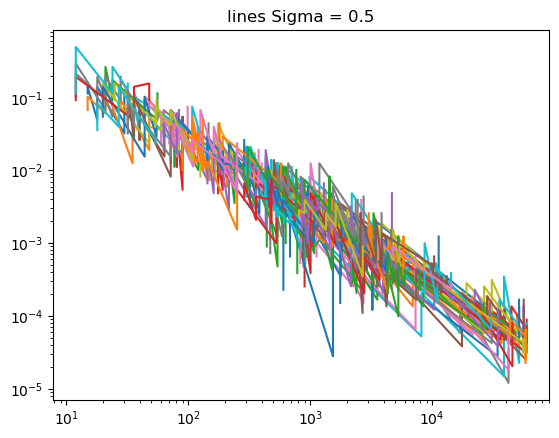

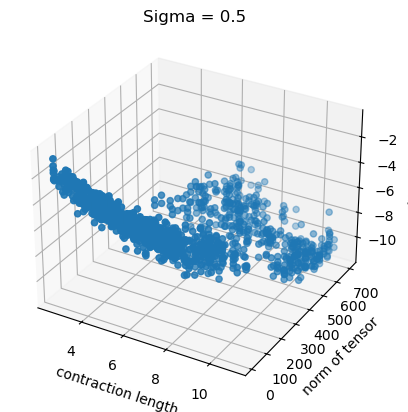

 
 
 Sigma = 0.1
Dimension of new tensor: [54, 133, 5, 5]
doing 7 iteration steps, with norm: 627.5412455693105
done with factorization
Dimension of new tensor: [99, 21, 70]
doing 9 iteration steps, with norm: 451.401061044955
done with factorization
Dimension of new tensor: [84, 30, 42]
doing 8 iteration steps, with norm: 366.2139703062009
done with factorization
Dimension of new tensor: [30, 142, 30]
doing 10 iteration steps, with norm: 458.0498058471751
done with factorization
Dimension of new tensor: [167, 24, 28]
doing 7 iteration steps, with norm: 389.7347535621246
done with factorization
Dimension of new tensor: [159, 31, 26]
doing 6 iteration steps, with norm: 413.1921241184693
done with factorization
Dimension of new tensor: [39, 188, 3, 4]
doing 9 iteration steps, with norm: 341.57332809122056
done with factorization
Dimension of new tensor: [192, 22, 10, 4]
doing 8 iteration steps, with norm: 590.0092128557684
done with factorization
Dimension of new tensor: [45, 85, 9, 5]
d

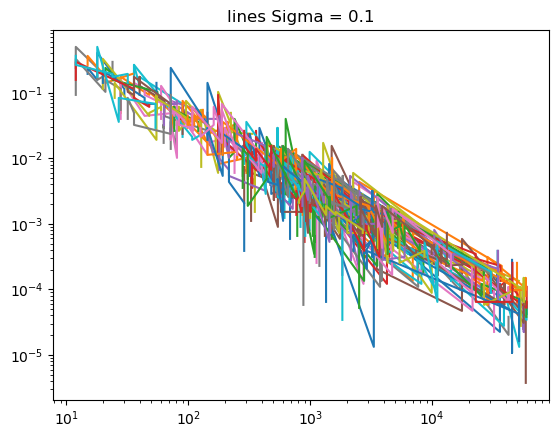

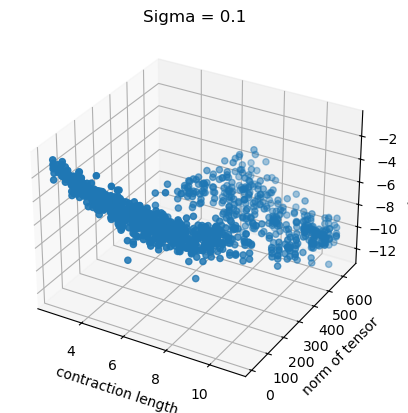

 
 
 Sigma = 0.001
Dimension of new tensor: [54, 133, 5, 5]
doing 6 iteration steps, with norm: 483.18831870703923
done with factorization
Dimension of new tensor: [99, 21, 70]
doing 6 iteration steps, with norm: 432.99722976925443
done with factorization
Dimension of new tensor: [84, 30, 42]
doing 6 iteration steps, with norm: 411.9888378246784
done with factorization
Dimension of new tensor: [30, 142, 30]
doing 8 iteration steps, with norm: 423.828562710651
done with factorization
Dimension of new tensor: [167, 24, 28]
doing 7 iteration steps, with norm: 390.0579527833911
done with factorization
Dimension of new tensor: [159, 31, 26]
doing 7 iteration steps, with norm: 401.76661251605844
done with factorization
Dimension of new tensor: [39, 188, 3, 4]
doing 7 iteration steps, with norm: 421.0586686078107
done with factorization
Dimension of new tensor: [192, 22, 10, 4]
doing 7 iteration steps, with norm: 469.9902477443946
done with factorization
Dimension of new tensor: [45, 85, 9, 5

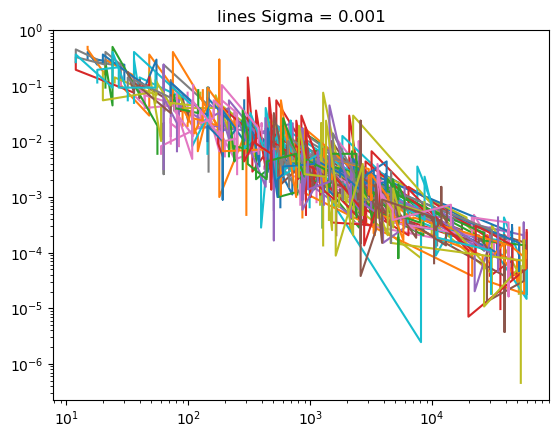

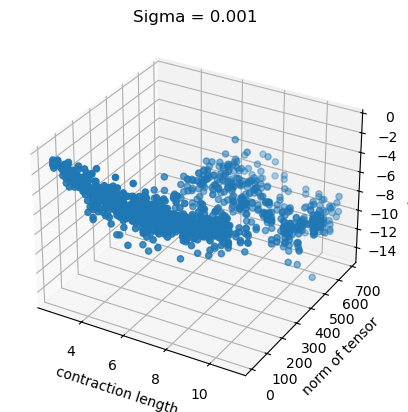

In [4]:
# Trying do plot many stuff things, you know...
# TODO make this use GPU! For some reason this is super slow on GPU even though it should be very fast?
#tl.set_backend('pytorch')
#context = {'dtype': tl.float32,
#           'device': 'cuda'}
tl.set_backend('numpy')
context = {}

dimensions = []
# add large tensors
for _ in range(50):
    ndim = random.randint(3, 5)
    dimension = []

    max_dimension = 300*300*2
    # TODO make tensor generation smarter so that we dont generate massive ones!
    for n in range(ndim):
        next_dimension = random.randint(3, max( min( int(max_dimension / 3**(ndim-n -1)), 200) , 3 ) )
        dimension.append(next_dimension)
        max_dimension /= next_dimension
        
    dimensions.append(dimension)

# add small tensors
for _ in range(100):
    ndim = random.randint(3, 5)
    dimension = []

    for _ in range(ndim):
        next_dimension = random.randint(3, 12 )
        dimension.append(next_dimension)
        
    dimensions.append(dimension)

# let us also test different sigma values
alpha = 0.5
beta = 0.9
sigmas = [0.5, 0.1, 0.001]

points_for_sigma = {}


for sigma in sigmas:
    print(" \n \n Sigma = " + str(sigma))
    all_points = [] # list containing all points
    
    # big tensors only for now
    for dimension in dimensions:
        print("Dimension of new tensor: " + str(dimension))
        
        F = random.randint(2, 5) # get random order between 2 and 5
        max_iter = random.randint(6, 10) # get a random iteration between 5 and 10 
        #scaling = random.uniform(0.1, 100.0) # get a random norm for our tensor
        
        data_of_tensor = []
        
        tensor = random_cp_with_noise(dimension, F, noise_scaling=0.0, context=context) # make it have no noise
        tensor = tensor / tl.mean(tensor) # make sure that mean=1
        norm_of_tensor = tl.norm(tensor)

        
        print("doing " + str(max_iter) + " iteration steps, with norm: " + str(norm_of_tensor))

        # creating initial data
        initial_A_ns = create_initial_data(tensor, F)
        #norm_approx = tl.norm( defactorizing_CP(initial_A_ns, tensor.shape) )
        #scaling = (norm_of_tensor / norm_approx) ** (1.0/ tensor.ndim)
        #for n in range(len(initial_A_ns)):
        #    initial_A_ns[n] = initial_A_ns[n] * scaling
        backtracking_failed = False
        with warnings.catch_warnings(record=True) as w:
            # ignore runtimewarnings as they come from stuff that doesnt matter
            warnings.simplefilter("ignore", RuntimeWarning)
            # userwarnings are my warning that backtracking failed
            warnings.simplefilter("always", BacktrackingWarning)
            
            A_ns, _, _, step_size_modfiers = tensor_factorization_cp_poisson(tensor, F, max_iter=max_iter, detailed=True, verbose=False, sigma=sigma, beta=beta, initial_A_ns=initial_A_ns)
            print("done with factorization")
            
            if w:
                print("Warnings were issued during the function call, skipping tensor")
                if issubclass(warning.category, BacktrackingWarning):
                    print(f"Caught UserWarning: {warning.message}")
                    special_warning_issued = True
                else:
                    # Optionally store or print other captured warnings if you want to see what was ignored
                    print(f"Caught other warning (ignored): {warning.message} ({warning.category.__name__})")

        if backtracking_failed:
            continue
            
        for k in range(2): # always use the 2 last iterations to get bit more data points for free
            for n in range(tensor.ndim):
                khatr_rao_product = tl.tenalg.khatri_rao(A_ns, skip_matrix=n)
                data_of_tensor.append( {
                    "contraction" : khatr_rao_product.shape[0], 
                    "norm_Ans" : tl.norm(khatr_rao_product),
                    "mean_Ans" : tl.mean(khatr_rao_product),
                    "max_Ans" : tl.max(khatr_rao_product),
                    "norm" : norm_of_tensor, 
                    "max" : tl.max(tensor),
                    "min" : tl.min(tensor),
                    "mean" : tl.mean(tensor),
                    "step_size" : alpha*math.pow(beta, step_size_modfiers[n][-k]) 
                } )

        # TODO: sort the points by contraction lenght so that plot looks better
        data_of_tensor = sorted(data_of_tensor, key=lambda x : x["contraction"])
        all_points.extend(data_of_tensor) # add the points from this tensor to the list of all points
        contraction_lenghts = [e["contraction"] for e in data_of_tensor]
        step_sizes = [e["step_size"] for e in data_of_tensor]
        plt.plot(contraction_lenghts, step_sizes)
    
    plt.xscale('log')
    plt.yscale('log')
    plt.title("lines Sigma = " + str(sigma))
    plt.show()
    
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')

    # this time do the log ourselfs
    contraction_lenghts = [math.log(e["contraction"]) for e in all_points]
    norms = [e["norm"] for e in all_points]
    step_sizes = [math.log(e["step_size"]) for e in all_points]
    
    ax.scatter(contraction_lenghts, norms, step_sizes)
    #ax.set_xscale('log')
    #ax.set_yscale('log')

    ax.set_xlabel('contraction length')
    ax.set_ylabel('norm of tensor')
    ax.set_zlabel('step size')
    ax.set_title("Sigma = " + str(sigma))
    plt.show()

    points_for_sigma[sigma] = deepcopy(all_points)

try:
    pickle.dump( points_for_sigma, open(data_folder+'optimal_stepsize_mean=1.pickle', 'wb') )
except Exception as e: print(e)

# Plot Data

In [5]:
def fit_plane(points):
    """
    Fits the best 2D polynomial (plane) of the form z = ax + by + c to a set of 3D points.
    
    Args:
    points: A list or numpy array of 3D points, where each point is represented as [x, y, z].
    
    Returns:
    A tuple (a, b, c) representing the coefficients of the fitted plane.
    Returns None if there are fewer than 3 points.
    """
    points = np.array(points)
    if points.shape[0] < 3:
        print("Error: Need at least 3 points to fit a plane.")
        return None
    
    x = points[:, 0]
    y = points[:, 1]
    z = points[:, 2]
    
    # Construct the matrix A and  vector b for the least squares fit
    # The equation is z = a*x + b*y + c, which can be written as:
    # [x1 y1 1] [a]   [z1]
    # [x2 y2 1] [b] = [z2]
    # ...       [c]   [...]
    A = np.vstack([x, y, np.ones(len(x))]).T
    b = z
    
    # Solve the least squares problem using numpy.linalg.lstsq
    coefficients, residuals, rank, s = np.linalg.lstsq(A, b, rcond=None)
    print("residual was " + str(residuals))
    
    # The coefficients are in the order [a, b, c]
    a, b, c = coefficients
    
    return a, b, c

 
 
 Sigma = 0.5
Now testing norm
residual was [900.19414259]
(-0.8679711540422865, -0.00011958713810600297, -1.2686452568957312)
so our formula is: step size = 0.2812123343070534 * length^(-0.8679711540422865) * e^(-0.00011958713810600297 norm)


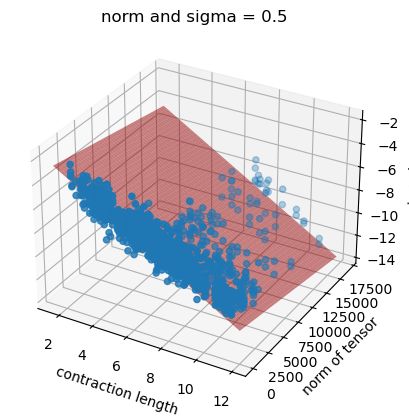

Now testing max
residual was [697.51410799]
(-0.9294891262956707, -0.015313174799187826, -0.26733231385754214)
so our formula is: step size = 0.765418669966292 * length^(-0.9294891262956707) * e^(-0.015313174799187826 max)


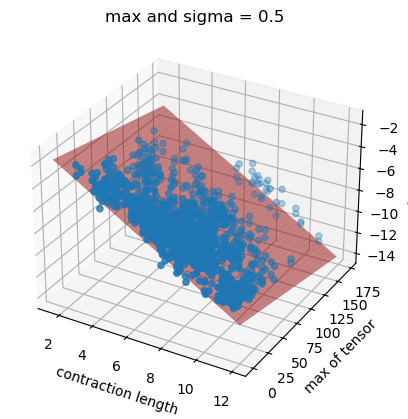

Now testing min
residual was [1009.48808065]
(-0.9801202364806398, -0.12468175475725263, -0.6573390085752415)
so our formula is: step size = 0.5182285029647755 * length^(-0.9801202364806398) * e^(-0.12468175475725263 min)


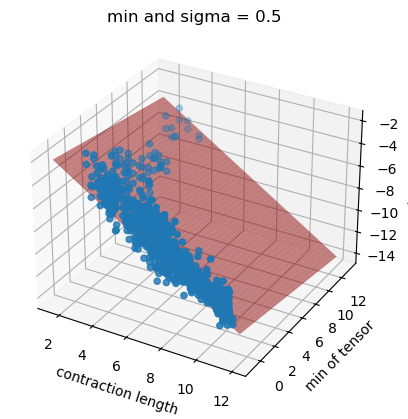

Now testing mean
residual was [794.43849334]
(-1.007586327718675, -0.04840547052717385, -0.010709440220271833)
so our formula is: step size = 0.9893477016668515 * length^(-1.007586327718675) * e^(-0.04840547052717385 mean)


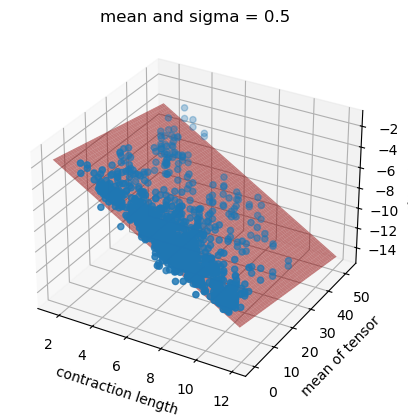

 
 
 Sigma = 0.1
Now testing norm
residual was [1021.10295105]
(-0.833513181011974, -0.00011511807347903448, -1.245863796853986)
so our formula is: step size = 0.28769229307210437 * length^(-0.833513181011974) * e^(-0.00011511807347903448 norm)


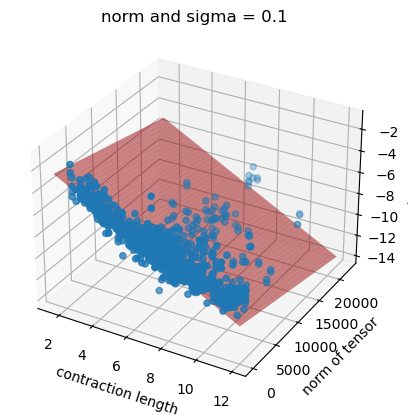

Now testing max
residual was [851.35749283]
(-0.9013105392679048, -0.013436970222510804, -0.2678718126941269)
so our formula is: step size = 0.7650058388553103 * length^(-0.9013105392679048) * e^(-0.013436970222510804 max)


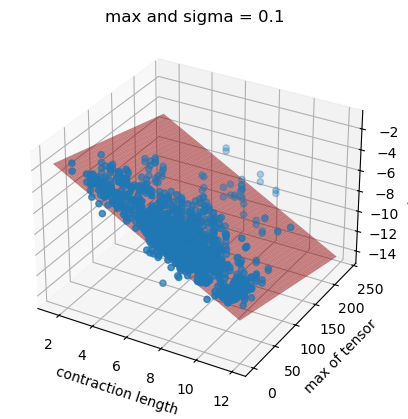

Now testing min
residual was [1163.23779544]
(-0.9334651953041273, -0.13461297787451088, -0.7296200383426402)
so our formula is: step size = 0.4820921318199879 * length^(-0.9334651953041273) * e^(-0.13461297787451088 min)


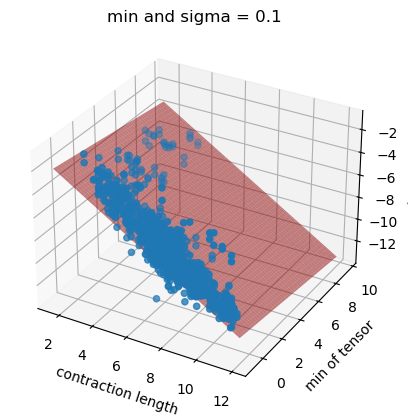

Now testing mean
residual was [953.46530779]
(-0.9605591797117559, -0.04346876189175009, -0.1082279988012637)
so our formula is: step size = 0.8974229617435856 * length^(-0.9605591797117559) * e^(-0.04346876189175009 mean)


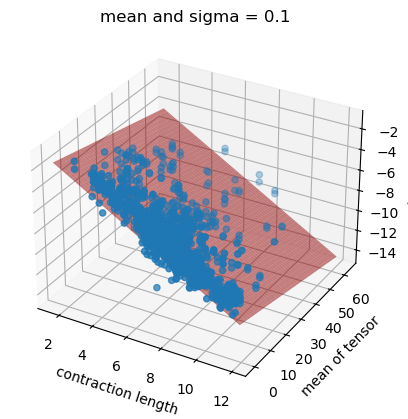

 
 
 Sigma = 0.001
Now testing norm
residual was [1388.00268592]
(-0.8246296503190123, -0.0001326482971535036, -1.0327092137629732)
so our formula is: step size = 0.35604106140254943 * length^(-0.8246296503190123) * e^(-0.0001326482971535036 norm)


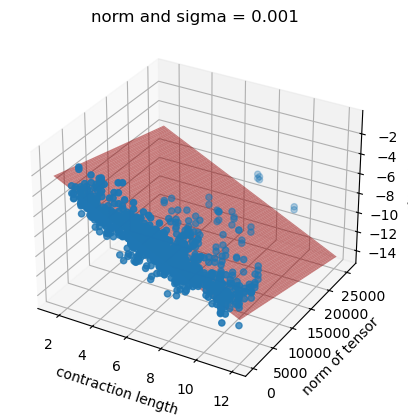

Now testing max
residual was [1146.0125462]
(-0.9227579445508092, -0.014626456762686618, 0.16153438998154296)
so our formula is: step size = 1.1753128764515075 * length^(-0.9227579445508092) * e^(-0.014626456762686618 max)


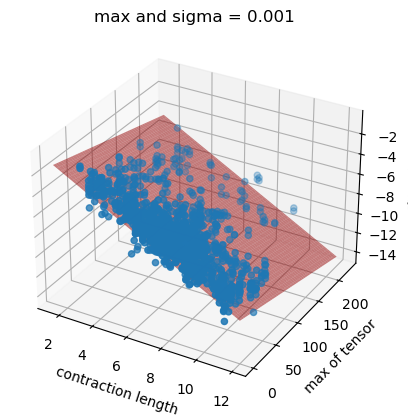

Now testing min
residual was [1526.82897373]
(-0.9482543933605952, -0.18466845899351825, -0.3341086821385516)
so our formula is: step size = 0.7159759641996295 * length^(-0.9482543933605952) * e^(-0.18466845899351825 min)


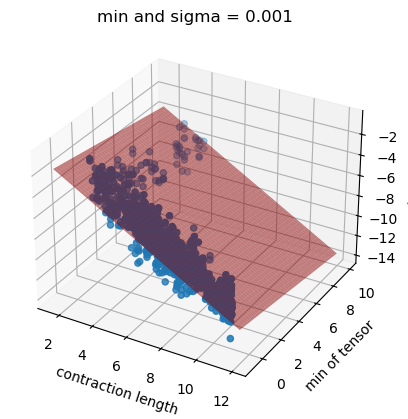

Now testing mean
residual was [1279.347002]
(-0.980137750098555, -0.04420838248991746, 0.281776192263158)
so our formula is: step size = 1.3254820336535054 * length^(-0.980137750098555) * e^(-0.04420838248991746 mean)


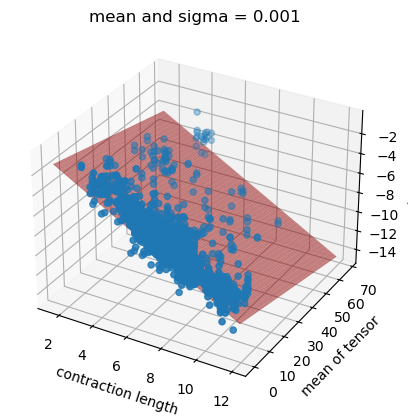

In [16]:
file = open(data_folder+"optimal_stepsize.pickle",'rb')
points_for_sigma = pickle.load(file)
file.close()

# iterate over all sigmas and print and plot the data
for sigma, all_points in points_for_sigma.items():
    print(" \n \n Sigma = " + str(sigma))
    
    contraction_lenghts = [math.log(e["contraction"]) for e in all_points]
    scaling_types = {
        "norm" : [e["norm"] for e in all_points],
        "max" : [e["max"] for e in all_points],
        "min" : [e["min"] for e in all_points],
        "mean" : [e["mean"] for e in all_points],
    }
    step_sizes = [math.log(e["step_size"]) for e in all_points]

    for name, data in scaling_types.items():
        print("Now testing " + name)
        
        fig = plt.figure()
        ax = fig.add_subplot(projection='3d')
        ax.scatter(contraction_lenghts, data, step_sizes)
        #ax.set_xscale('log')
        #ax.set_yscale('log')
    
        ax.set_xlabel('contraction length')
        ax.set_ylabel(name+' of tensor')
        ax.set_zlabel('step size')
        ax.set_title(name+" and sigma = " + str(sigma))
        #plt.show()
    
        # let us now find the best 1d line through these points in loglog
        points = [(math.log(p["contraction"]), p[name], math.log(p["step_size"])) for p in all_points]
        coefficients = fit_plane(points)
        print(coefficients)
        # recalculate to exponential formula
        print("so our formula is: step size = "+str(math.pow(10, coefficients[2]))+" * length^("+str(coefficients[0])+") * e^("+str(coefficients[1])+" "+name+")")
        #p = np.poly1d(z)
        #xp = np.linspace(min(x)-1, max(x)+1, 100)
        
        #_ = plt.plot(x, y, '.', xp, p(xp), '-')
        #plt.title("Sigma = " + str(sigma))
        a, b, c = coefficients 
        xp = np.linspace(min(contraction_lenghts)-1, max(contraction_lenghts)+1, 100)
        yp = np.linspace(min(data)-1, max(data)+1, 100)
        X, Y = np.meshgrid(xp, yp)
        Z = a * X + b * Y + c
        ax.plot_surface(X, Y, Z, color='red', alpha=0.5, label='Fitted Plane')
        plt.show()

## Plot with Mean = 1

 
 
 Sigma = 0.5
[-0.97567434  0.73698254]
so our formula is: step size = 2.0896206434894014 * lenght^(-0.9756743447666584)
 
 
 Sigma = 0.1
[-1.00846394  1.23612913]
so our formula is: step size = 3.4422631000970982 * lenght^(-1.0084639391202959)
 
 
 Sigma = 0.001
[-1.00179032  1.22982381]
so our formula is: step size = 3.420626795226345 * lenght^(-1.0017903209389056)


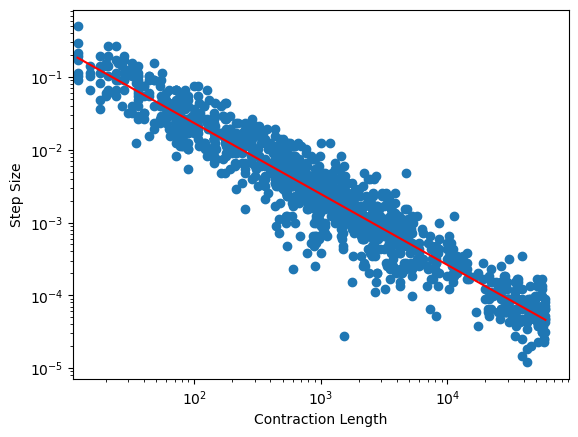

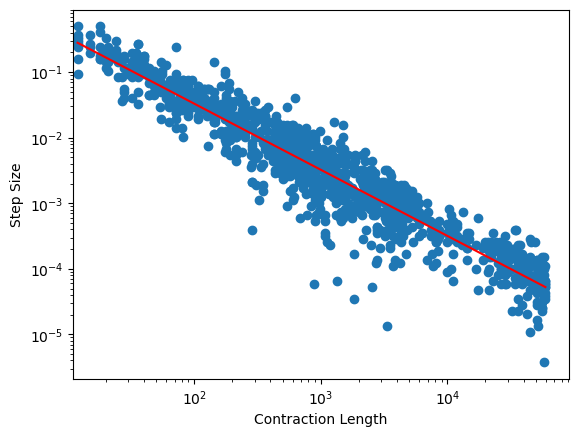

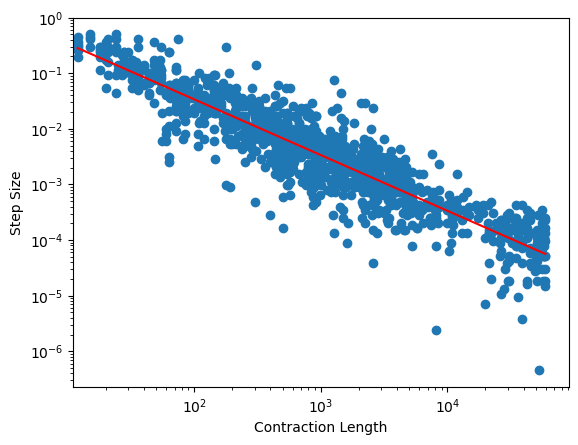

In [11]:
file = open(data_folder+"optimal_stepsize_mean=1.pickle",'rb')
points_for_sigma = pickle.load(file)
file.close()
variant = "contraction"

# iterate over all sigmas and print and plot the data
for sigma, all_points in points_for_sigma.items():
    print(" \n \n Sigma = " + str(sigma))
    
    contraction_lenghts = [math.log(e[variant]) for e in all_points]
    scaling_types = {
        "norm" : [e["norm"] for e in all_points],
        "max" : [e["max"] for e in all_points],
        "min" : [e["min"] for e in all_points],
        "mean" : [e["mean"] for e in all_points],
    }
    step_sizes = [math.log(e["step_size"]) for e in all_points]

    #print(scaling_types["mean"])

    x = [e[variant] for e in all_points]
    y = [e["step_size"] for e in all_points]

    plt.figure()
    plt.scatter(x, y)
    line = np.polyfit(contraction_lenghts, step_sizes, 1)
    print(line)
    print(f"so our formula is: step size = {math.exp(line[1])} * lenght^({line[0]})")
    #print("so our formula is: step size = "+str(math.pow(10, coefficients[2]))+" * length^("+str(coefficients[0])+") * e^("+str(coefficients[1])+" "+name+")")
    plt.plot(np.exp(np.unique(contraction_lenghts)), np.exp(np.poly1d(line)(np.unique(contraction_lenghts))), color="red")
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("Contraction Length")
    plt.ylabel("Step Size")
    plt.xlim(left=min(x)-1)
    plt.savefig(f"{picture_folder}step_size-contraction_length_{sigma}sigma.png")

## Plotting the Step Sizes for one Tensor

In [28]:
# Rescaling A_ns so that norm of approx is same as tensor X
# TODO think about if that is the correct method or if we want something better
context = {}

alpha = 1.0
beta = 0.9
sigma = 0.1
dimension = [30, 20, 10]
F = 4

max_iter = 2000
tensor = random_cp_with_noise(dimension, F, noise_scaling=0.01, context=context) # make it have no noise
tensor = tensor / tl.mean(tensor) # make sure that mean=1

print("doing " + str(max_iter) + " iteration steps, with norm: " + str(tl.norm(tensor)))


_, RE, approx, step_size_modifiers = tensor_factorization_cp_poisson(tensor, F, max_iter=max_iter, detailed=True, verbose=False, sigma=sigma, beta=beta, alpha=alpha)


doing 2000 iteration steps, with norm: 84.95960770722813


doing 2000 iteration steps, with norm: 88.35589236764373

 
 Tensor with final error 0.010130829855827476


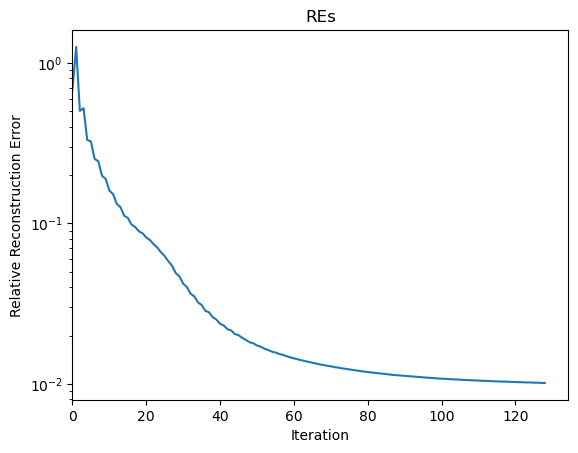

Mean step size after 4 iterations = 0.0482147491422149
Mean step size after 4 iterations = 0.010048500170544114
Mean step size after 4 iterations = 0.005954486371732675


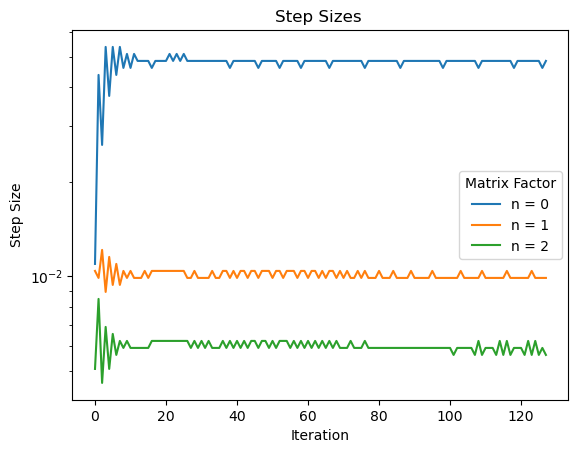

In [3]:
# Rescaling A_ns so that norm of approx is same as tensor X
# TODO think about if that is the correct method or if we want something better
context = {}

alpha = 1.0
beta = 0.95
sigma = 0.1
dimension = [30, 20, 10]
F = 4

max_iter = 2000
tensor = random_cp_with_noise(dimension, F, noise_scaling=0.01, context=context) # make it have no noise
tensor = tensor / tl.mean(tensor) # make sure that mean=1

print("doing " + str(max_iter) + " iteration steps, with norm: " + str(tl.norm(tensor)))


_, RE, approx, step_size_modifiers = tensor_factorization_cp_poisson(tensor, F, max_iter=max_iter, detailed=True, verbose=False, sigma=sigma, beta=beta, alpha=alpha)



print("\n \n Tensor with final error " + str(RE[-1]))
plt.plot(RE, label="Normal Stuff")


plt.title("REs")
plt.xlabel(iteration_label)
plt.ylabel(error_label)
# TODO das mal noch genauer anschauen, was da sinnvoll ist
plt.yscale(yscale_convergence)
#plt.xscale(xscale_convergence)
#plt.xscale(**xscale_convergence_data)
plt.xlim(left=0)
#plt.legend(title='Variants', loc='upper right')
plt.show()


plt.figure()
for n in range(tensor.ndim):
    step_size = [alpha*math.pow(beta, modifier) for modifier in step_size_modifiers[n]]
    mean_step_size = np.mean(step_size[50:])
    print(f"Mean step size after 4 iterations = {mean_step_size}")
    plt.plot(step_size, label=f"n = {n}")
plt.title("Step Sizes ")
plt.legend(title='Matrix Factor')
plt.yscale("log")
plt.xlabel(iteration_label)
plt.ylabel("Step Size")
plt.savefig(f"{picture_folder}step_size_oscillation.png")

# Testing on India Pines

C:\Users\David\.conda\envs\tensor_factorization\lib\site-packages\tensorly\backend\pytorch_backend.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(



 
 unscaled Tensor
took 2.862 seconds with final error 0.11963146924972534

 
 mean=1 Tensor
took 3.187 seconds with final error 0.11915100365877151

 
 max=1 Tensor
took 2.780 seconds with final error 0.11885488033294678


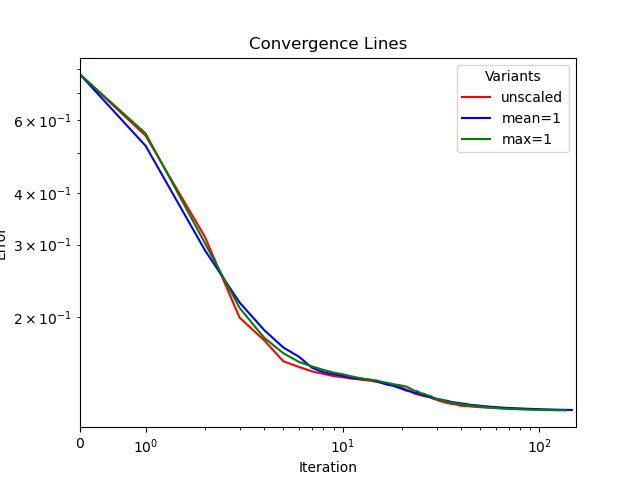

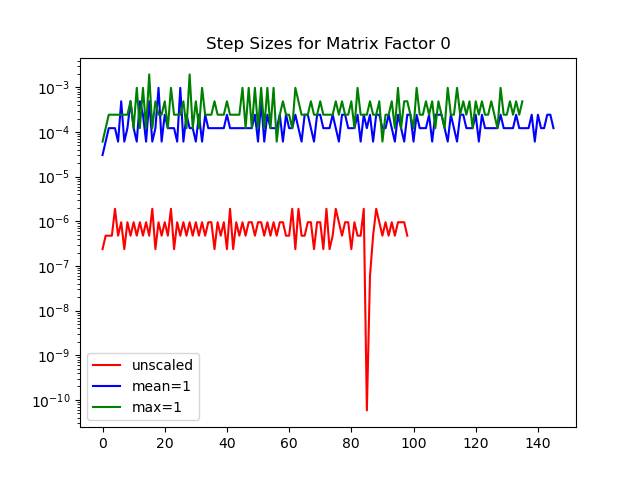

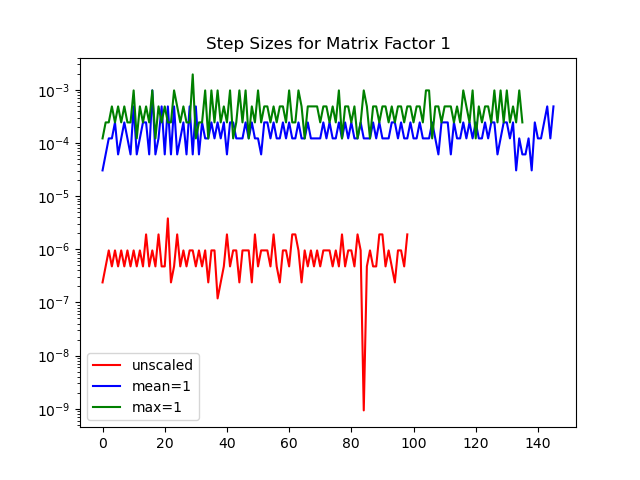

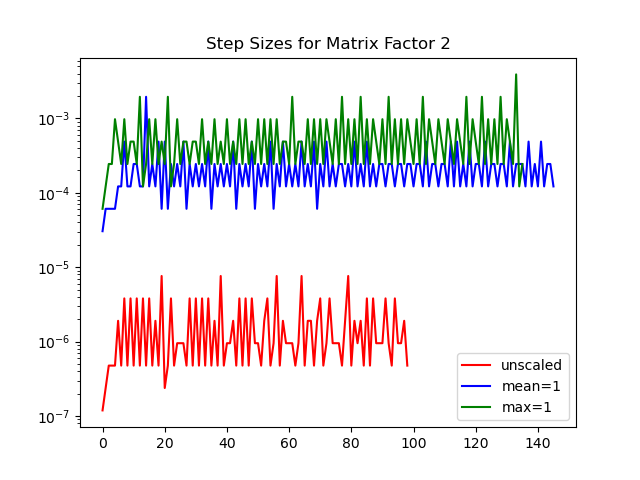

In [2]:
tl.set_backend('pytorch')
context = {'dtype': tl.float32,
           'device': 'cuda'}
indian_pines = load_indian_pines()
tensor = tl.tensor(indian_pines.tensor, **context)

show_step_sizes(tensor)

In [11]:
tl.set_backend('pytorch')
context = {'dtype': tl.float32,
           'device': 'cuda'}

print("\nTesting on indian pines data:")
indian_pines = load_indian_pines()
tensor = tl.tensor(indian_pines.tensor, **context)
tensor = tensor*100.0
#tensor = tensor / tl.max(tensor)
print("Tensor is of shape: " + str(tensor.shape)+" with min: "+str(tl.min(tensor))+", max: "+str(tl.max(tensor))+", average: "+str(tl.mean(tensor)))
F = 4 # TODO find good F here
# generate initial A_ns
initial_A_ns = create_initial_data(tensor, F)

tensor_factorization_cp_poisson(tensor,F,max_iter=3,verbose=True, initial_A_ns=initial_A_ns)


Testing on indian pines data:
Tensor is of shape: torch.Size([145, 145, 200]) with min: tensor(95500., device='cuda:0'), max: tensor(960400., device='cuda:0'), average: tensor(265238.9375, device='cuda:0')
Current index: 0
Initial m = 17
Biggest element in -gradient: tensor(1.4619e+08, device='cuda:0')
smallest element in -gradient: tensor(-21132168., device='cuda:0')
Time from start to calculate gradients and first next iterate: 0.10106086730957031
Time from start until end of step size calculation: 0.23111867904663086
Step Size: 1.4901161193847656e-08
m: 25
Step size * biggest element: tensor(2.1784, device='cuda:0')
biggest element in A_n: tensor(82.2256, device='cuda:0')
smallest element in A_n: tensor(0.3250, device='cuda:0')
Shape of approximated_X_unfolded_n: torch.Size([145, 29000])
Shape of khatri Rao product: torch.Size([29000, 4])
Calculculation time: 0.23611855506896973
New objective function value: tensor(-1.2641e+13, device='cuda:0')
function_value_at_iteration = tensor(

[tensor([[ 48.3878,  16.0952,  50.0360,  46.5963],
         [ 62.0744,  58.6326,  13.3421,  48.8358],
         [  7.7630,  59.1335,  38.0683,  59.2756],
         [ 31.8604,  59.4977,  41.0822,  21.9553],
         [ 27.5717,  51.8317,  50.4974,  52.4710],
         [ 56.8221,  35.9979,  45.3262,  38.5508],
         [  3.0089,  79.1658,  28.2115,  49.1463],
         [ 97.3780,  24.9865,  55.5545,  63.3517],
         [ 60.9068,  37.1227,  55.4225,  49.7199],
         [ 58.1500,  43.5225,  55.7218,   6.6077],
         [ 59.5715,  58.7019,   0.4134,  66.4591],
         [ 25.3362,  55.6126,  69.0299,   9.5530],
         [ 59.8298,  53.7667,  45.2293,  45.3304],
         [ 41.9231,  45.1707,   2.6310,  64.9068],
         [ 39.6666,   1.1350,  30.7200,  92.5162],
         [ 43.5349,  12.3999,  50.2174,  52.8042],
         [ 41.5742,  25.8799,  37.3553,  63.0836],
         [ 33.8232,  21.8577,  64.4714,  48.2040],
         [ 36.5008,  10.7780,  72.4422,  51.5690],
         [ 54.5067,  27.6191,  